# Medical image segmentation with text-based prompts (Inference; Experimental Functionality)

In this tutorial, we will show how to use text prompts for medical image segmentation. Algothgh SAM has not released the text-based segmentation, we can implement this function by ourselves since there are many pre-trained text encoders in the community. 
We used the [MICCAI FLARE 2022](https://zenodo.org/record/7860267) dataset as an example. This is an abdominal organ segmentation task and there are 13 different organs as shown in the following figure. 

![FLARE22](https://rumc-gcorg-p-public.s3.amazonaws.com/i/2022/03/29/20220309-FLARE22-Pictures-2.png)

Assume that you have trained the model following the [training pipeline](https://github.com/bowang-lab/MedSAM/tree/main/extensions/text_prompt). If not, you can use this [checkpoint](https://drive.google.com/file/d/12YH-N6PAKayulhS99MBURVNpuQtVj98S/view?usp=sharing). 

Note: please install this package: `pip install transformers`

In [1]:
#!pip install git+https://github.com/bowang-lab/MedSAM.git
#!pip install transformers

In [3]:
%matplotlib widget
from segment_anything import sam_model_registry
from ipywidgets import interact, widgets, FileUpload
from segment_anything.modeling import PromptEncoder
from transformers import CLIPTextModel
from typing import Any, Optional, Tuple, Type
from matplotlib import pyplot as plt
from copy import deepcopy
from torch import nn
from torch.nn import functional as F
import torch
import os
join = os.path.join
import cv2
import numpy as np
import SimpleITK as sitk
import warnings
warnings.filterwarnings('ignore')

## Define text prompt encoder

We used the pre-trained CLIP model as the text encoder. The prompt encoder in SAM maps all kinds of prompts to the same dimension (256) but the output dimension of CLIP model is 512. Thus, we added an additional projection layer `self.text_encoder_head = nn.Linear(512, embed_dim)` to the text encoder to align the dimension. 

In [4]:
class TextPromptEncoder(PromptEncoder):
    def __init__(
        self,
        embed_dim: int,
        image_embedding_size: Tuple[int, int],
        input_image_size: Tuple[int, int],
        mask_in_chans: int = 1,
        activation = nn.GELU,
        ) -> None:
        super().__init__(embed_dim, image_embedding_size, input_image_size, mask_in_chans, activation)
        text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch16")
        text_encoder.requires_grad_(False)
        self.text_encoder = text_encoder
        self.text_encoder_head = nn.Linear(512, embed_dim)

    def forward(
        self,
        points: Optional[Tuple[torch.Tensor, torch.Tensor]],
        boxes: Optional[torch.Tensor],
        masks: Optional[torch.Tensor],
        tokens: Optional[torch.Tensor],
    ):
        """
        Embeds different types of prompts, returning both sparse and dense
        embeddings.

        Arguments:
          points (tuple(torch.Tensor, torch.Tensor) or none): point coordinates
            and labels to embed.
          boxes (torch.Tensor or none): boxes to embed
          masks (torch.Tensor or none): masks to embed

        Returns:
          torch.Tensor: sparse embeddings for the points and boxes, with shape
            BxNx(embed_dim), where N is determined by the number of input points
            and boxes.
          torch.Tensor: dense embeddings for the masks, in the shape
            Bx(embed_dim)x(embed_H)x(embed_W)
        """
        bs = self._get_batch_size(points, boxes, masks, tokens)
        sparse_embeddings = torch.empty(
            (bs, 0, self.embed_dim), device=self._get_device()
        )
        if points is not None:
            coords, labels = points
            point_embeddings = self._embed_points(coords, labels, pad=(boxes is None))
            sparse_embeddings = torch.cat([sparse_embeddings, point_embeddings], dim=1)
        if boxes is not None:
            box_embeddings = self._embed_boxes(boxes)
            sparse_embeddings = torch.cat([sparse_embeddings, box_embeddings], dim=1)
        if tokens is not None:
            encoder_hidden_states = self.text_encoder(tokens)[0]
            text_embeddings = self.text_encoder_head(encoder_hidden_states)
            sparse_embeddings = torch.cat([sparse_embeddings, text_embeddings], dim=1)

        if masks is not None:
            dense_embeddings = self._embed_masks(masks)
        else:
            dense_embeddings = self.no_mask_embed.weight.reshape(1, -1, 1, 1).expand(
                bs, -1, self.image_embedding_size[0], self.image_embedding_size[1]
            )

        return sparse_embeddings, dense_embeddings
    
    def _get_batch_size(self, points, boxes, masks, tokens):
        """
        Returns the batch size of the inputs.
        """
        if points is not None:
            return points[0].shape[0]
        elif boxes is not None:
            return boxes.shape[0]
        elif masks is not None:
            return masks.shape[0]
        elif tokens is not None:
            return tokens.shape[0]
        else:
            return 1

## Define the whole model

The whole model architecture is the same as the bounding box-based version. The only difference is that the prompt encoder was changed to text encoder.
Since MedSAM already provided an image encoder trained on a large scale medical image datasets, we can freeze it and only fine-tune the mask decoder during training. 

In [5]:
class MedSAMText(nn.Module):
    def __init__(self, 
                image_encoder, 
                mask_decoder,
                prompt_encoder,
                device,
                ):
        super().__init__()
        self.image_encoder = image_encoder
        self.mask_decoder = mask_decoder
        self.prompt_encoder = prompt_encoder
        self.device = device

    def forward(self, image, tokens):
        image_embedding = self.image_encoder(image) # (B, 256, 64, 64)
        sparse_embeddings, dense_embeddings = self.prompt_encoder(
            points=None,
            boxes=None,
            masks=None,
            tokens=tokens
        )
        low_res_logits, _ = self.mask_decoder(
            image_embeddings=image_embedding, # (B, 256, 64, 64)
            image_pe=self.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
            multimask_output=False,
          ) # (B, 1, 256, 256)

        return low_res_logits

## Load pre-trained model

Two models should be loaded:
- the pre-trained MedSAM model
- The text encoder and fine-tuned mask decoder

In [7]:
medsam_ckpt_path = "medsam_vit_b.pth"
device = "cuda:0"
medsam_model = sam_model_registry['vit_b'](checkpoint=medsam_ckpt_path)
medsam_text_demo_checkpoint = "medsam_text_prompt_flare22.pth"
text_prompt_encoder = TextPromptEncoder(
    embed_dim = 256,
    image_embedding_size = (64, 64),
    input_image_size = (1024, 1024),
    mask_in_chans = 1
)
medsam_text_demo = MedSAMText(
    image_encoder=deepcopy(medsam_model.image_encoder),
    mask_decoder=deepcopy(medsam_model.mask_decoder),
    prompt_encoder=text_prompt_encoder,
    device = device
)
medsam_text_demo_weights = torch.load(medsam_text_demo_checkpoint)
for key in medsam_text_demo.state_dict().keys():
    if not key.startswith('prompt_encoder.text_encoder.'):
        medsam_text_demo.state_dict()[key].copy_(medsam_text_demo_weights[key])
medsam_text_demo = medsam_text_demo.to(device)
medsam_text_demo.eval()

MedSAMText(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()

Here is a GUI for testing the text-based segmentation

In [11]:
class TextPromptDemo:
    def __init__(self, model):
        ## Requires transformers only if users would like to try text prompt
        from transformers import CLIPTokenizer
        self.tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch16")   
        self.model = model
        self.model.eval()
        self.image = None
        self.image_embeddings = None
        self.img_size = None
        self.img_name = None
        self.gt = None
        self.label_dict = {
            1: ["liver"],
            2: ["right kidney"],
            3: ["spleen"],
            4: ["pancreas"],
            5: ["aorta"],
            6: ["inferior vena cava", "ivc"],
            7: ["right adrenal gland", "rag"],
            8: ["left adrenal gland", "lag"],
            9: ["gallbladder"],
            10: ["esophagus"],
            11: ["stomach"],
            12: ["duodenum"],
            13: ["left kidney"]
        }
        self.caption_label_dict = {}
        for label_id, label_list in self.label_dict.items():
            for label in label_list:
                self.caption_label_dict[label] = label_id

        avail_prompts = []
        for v in self.label_dict.values():
            avail_prompts += v
        self.avail_prompts = ", ".join(avail_prompts)

    def show_mask(self, mask, ax, random_color=False, alpha=0.95):
        if random_color:
            color = np.concatenate([np.random.random(3), np.array([alpha])], axis=0)
        else:
            color = np.array([251/255, 252/255, 30/255, alpha])
        h, w = mask.shape[-2:]
        mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
        ax.imshow(mask_image)
    
    @torch.no_grad()
    def infer(self, text):
        tokens = self.tokenize_text(text).to(self.model.device)
        sparse_embeddings, dense_embeddings = self.model.prompt_encoder(
            points = None,
            boxes = None,
            masks = None,
            tokens = tokens
        )
        low_res_logits, _ = self.model.mask_decoder(
            image_embeddings=self.image_embeddings, # (B, 256, 64, 64)
            image_pe=self.model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
            multimask_output=False,
            )
        low_res_pred = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)
        low_res_pred = F.interpolate(
            low_res_pred,
            size = self.img_size,
            mode = 'bilinear',
            align_corners = False
        )
        low_res_pred = low_res_pred.detach().cpu().numpy().squeeze()
        seg = np.uint8(low_res_pred > 0.5)

        return seg

    def show(self, fig_size=3, alpha=0.95):
        assert self.image is not None, "Please set image first."
        fig, ax = plt.subplots(1, 1, figsize=(fig_size, fig_size))
        fig.canvas.header_visible = False
        fig.canvas.footer_visible = False
        fig.canvas.toolbar_visible = False
        fig.canvas.resizable = False

        #avil_ids = np.unique(self.gt)[1:]
        print("Possible prompts:", self.avail_prompts)

        plt.tight_layout()

        ax.imshow(np.rot90(self.image, 2), cmap='gray')
        ax.axis('off')

        text = widgets.Text(
            value = '',
            placeholder = 'Prompt',
            description = 'Enter a prompt',
            disabled = False,
            style = {'description_width': 'initial'}
        )
        display(text)

        def callback(wget):
            caption = wget.value.lower().strip()
            if len(fig.texts) > 0:
                fig.texts[0].remove()
            if caption not in self.avail_prompts:
                fig.text(
                    0.50,
                    0.02,
                    f"Invalid prompt: {wget.value}",
                    horizontalalignment='center',
                    wrap=True,
                    color='r'
                )
            else:
                ax.clear()
                ax.imshow(np.rot90(self.image, 2), cmap='gray')
                ax.axis('off')
                seg = self.infer(caption)
                self.show_mask(np.rot90(seg, 2), ax, random_color=False, alpha=alpha)

        text.on_submit(callback)

    def set_image(self, image):
        self.image = image
        self.img_size = image.shape[:2]
        if len(image.shape) == 2:
            image = np.repeat(image[:,:,None], 3, -1)
        image_preprocess = self.preprocess_image(image)
        with torch.no_grad():
            self.image_embeddings = self.model.image_encoder(image_preprocess)
        
    def preprocess_image(self, image):
        img_resize = cv2.resize(
            image,
            (1024, 1024),
            interpolation=cv2.INTER_CUBIC
        )
        # Resizing
        img_resize = (img_resize - img_resize.min()) / np.clip(img_resize.max() - img_resize.min(), a_min=1e-8, a_max=None) # normalize to [0, 1], (H, W, 3
        # convert the shape to (3, H, W)
        assert np.max(img_resize)<=1.0 and np.min(img_resize)>=0.0, 'image should be normalized to [0, 1]'
        img_tensor = torch.tensor(img_resize).float().permute(2, 0, 1).unsqueeze(0).to(self.model.device)

        return img_tensor
    

    def tokenize_text(self, text):
        """
        Tokenize text using CLIP tokenizer
        """
        return self.tokenizer(
            text, max_length=self.tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt" 
        ).input_ids.squeeze(1)

## Load data and run inference

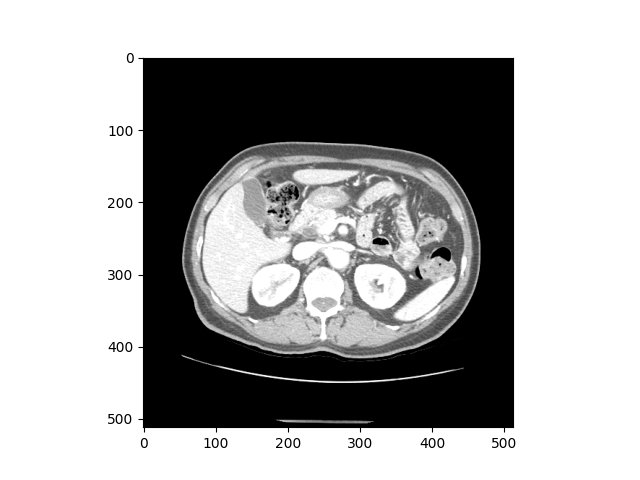

Text(0.5, 1.0, 'middle slice:46')

In [9]:
# load demo nii data
demo_file_nii = "../../data/FLARE22Train/images/FLARE22_Tr_0046_0000.nii.gz"
file_sitk = sitk.ReadImage(demo_file_nii)
image_data = sitk.GetArrayFromImage(file_sitk)
# adjust window width and level
lower_bound = -240.0
upper_bound = 160.0
image_data_pre = np.clip(image_data, lower_bound, upper_bound)
# normalize to [0, 255]
image_data_pre = (image_data_pre - np.min(image_data_pre))/(np.max(image_data_pre)-np.min(image_data_pre))*255.0
image_data_pre = np.uint8(image_data_pre)
# select middle slice; you can also manually select the slice that you want to test
image_slice_id = int(image_data_pre.shape[0]/2)
image_slice = image_data_pre[image_slice_id]
# show the image to check whether it contains abdominal organs
plt.imshow(np.rot90(image_slice, 2), cmap='gray')
plt.show()
plt.title('middle slice:'+str(image_slice_id))

input prompt in the following prompt box, e.g., liver and press `Enter`

![text-seg](text_seg_demo.gif)

Possible prompts: liver, right kidney, spleen, pancreas, aorta, inferior vena cava, ivc, right adrenal gland, rag, left adrenal gland, lag, gallbladder, esophagus, stomach, duodenum, left kidney


Text(value='', description='Enter a prompt', placeholder='Prompt', style=TextStyle(description_width='initial'…

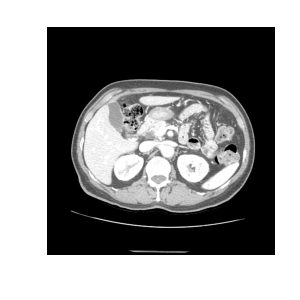

In [12]:
text_prompt_demo = TextPromptDemo(medsam_text_demo)
text_prompt_demo.set_image(image_slice)
text_prompt_demo.show()

## Closing remarks

This is still an experimental function at present. There is a large room for further improvements, such as open-vocabulary segmentation. Compared to other prompts, text-prompt provided a straightforward way to integrate partially labeled datasets since it eliminates the limation of fully labeled datasets in typical semantic segmentation tasks! We're excited about this research direction. 